# Numerical approximation of wavefunctions

Tarkan Yzeiri

## Code:

In [2]:
# interactive plots
%matplotlib notebook

# importing modules
import numpy as np
import matplotlib.pyplot as plt
import random

#### Below code cell defining the physical constants, half-width of the potential well, and number of RK calculation points:

In [3]:
m = 9.109383702*10**(-31) # electron mass (kg)
hbar = 1.054571817*10**(-34) # Plancks constant/2*pi - h bar (Js)
e = 1.602176634*10**(-19) # electron charge (C)

a = 5*10**(-11) # half-width of potential well (m)
N = 1000 # number of RK calculation points

### Defining potentials:

Below, the following potentials are defined:

(1):
$$ V_x = \begin{cases} 0 & \text{if } -a \leq x \leq +a, \\ 
\infty  & \text{if } |x| > a, \end{cases} 
$$

(2):
$$
V(x) = V_0 \frac{x^2}{a^2}
$$

(3):
$$
V_x = \begin{cases} 0 & \text{if } -a/2 \leq x \leq +a/2, \\ 
    V_0  & \text{if } |x| > a/2, \end{cases} 
$$

All above equations referenced from [1].

Potentials (2) and (3) are embedded in an infinite square well for $|x| > a$.

x-values will be calculated for $|x| < a$ with boundary conditions $ V(-a)=0 $ and $ V(a)=0 $ from the infinite square well.

In [4]:
def Vzero(x):
    """Calculates potential for V(x) = 0
    Input:
        x [string]: x point value (m)
    Output:
        Vzero(x) [string]: solutions for potential of V(x) = 0 in Joules (1)
    """
    
    return 0.0

In [5]:
def Vfinite(x):
    """Calculates potential for V(x) = V0finite for |x| >= a/2
    Input:
        x [string]: x point value (m)
    Output:
        Vfinite(x) [string]: solutions for the above potential in Joules (2)
    """
    
    if abs(x) > a/2:
        x = V0finite
        
    else:
        x = 0
        
    return x
#Constant inside Vfinite defined
V0finite = 600*e

In [6]:
def Vharmonic(x):
    """Calculates potential for V(x) = V0(x/a)**2
    Input:
        x [string]: x point value (m)
    Output:
        Vharmonic(x) [string]: solutions for the above potential in Joules (3)
    """
    
    return V0harmonic*(x/a)**2
#Constant inside Vharmonic defined
V0harmonic = 700*e

### Schrödinger equation and Runge Kutta:

Seperating the Schrödinger equation into two first-order differential equations allows you to obtain:

(4):
$$ \frac{d\psi}{dx} = \phi $$

(5):
$$ \frac{d\phi}{dx} = \frac{2m}{\hbar^2} [V(x)-E]\psi(x) $$

These two first-order differential equations [1] can then defined and be plugged into the Runge-Kutta method that solves simultaneous differential equations numerically.

In [7]:
def schrodinger(r,x,E,potential):
    """Time-independant Schrödinger equation (TISE) split into two first order differential equations
    Inputs:
        r [array]: vector of wavefunction r[0], psi and its differential r[1], phi
        x [string]: value of initial x point (m)
        E [string]: Energy for Schrödinger equation to be solved at (eV)
        potential [function name]: potential function to be used in first order differential equation (5)
    Outputs:
        [dpsi_dx,dphi_dx]: Initial numerical values of the simulataneous differential equations
    """
    psi = r[0] # first element of array r represents the wavefunction
    phi = r[1] # second element of array r represents the differential wavefunction with respect to x
    dpsi_dx = phi # d(psi)/dx = phi
    dphi_dx = 2*m/hbar**2 * (potential(x) - E*e) * psi # d(phi)/dx = 2m/hbar^2 * [V(x) - E] * psi(x)
    return np.array([dpsi_dx,dphi_dx])

The below Runge-Kutta for simulataneous differential equations was obtained from [2].

In [8]:
def RK2D(r,xpoints,E,potential):
    """Fourth-order Runge-Kutta used to solve two simultaneous equations
    Inputs:
        r [array]: array of values, one for each differential equation (r[0] as psi and r[1] as phi)
        xpoints [array]: x values to be inputted (m)
        E [string]: Energy for Schrödinger equation to be evaluated in the Runge Kutta (eV)
        potential [function name]: the potential function used to solve the system
    Outputs: 
        [psipoints, phipoints]: numerical solutions for psi(x) and phi(x), numpy arrays of same length as xpoints
    """
    
    psipoints = [] # initialise empty arrays
    phipoints = []
    
    for x in xpoints:
        psipoints.append(r[0])
        phipoints.append(r[1])
        k1 = h*schrodinger(r,x,E,potential) 
        k2 = h*schrodinger(r+0.5*k1, x+0.5*h, E,potential)
        k3 = h*schrodinger(r+0.5*k2, x+0.5*h, E,potential)
        k4 = h*schrodinger(r+k3, x+h, E,potential)
        r = r + (k1 + 2*k2 + 2*k3 + k4)/6
    # appends for the last two x values to the psipoints and phipoints arrays
    psipoints.append(r[0])
    phipoints.append(r[1])
    return np.array([psipoints, phipoints]) # convert output to numpy array with 2 rows and N columns

In [9]:
xi = -a # starting x point
xf = a # ending x point
N = 1000 # number of points for RK calculation
h = (xf - xi)/N # size of Runge-Kutta steps

xpoints = np.arange(xi, xf, h) # array of x points from start to end (with dx = h)

### Energy guessing and secant method:

The secant method was used, however for a function with multiple roots the secant method becomes inaccurate (guessing wrong roots). This can be improved by having sensible energy guesses for which the analytical energy root will be calculated at.

This is achieved by using the 'Eguesser' function below. The 'Eguesser' function takes into account how the wavefunction changes with consecutive energy states when using the Runge Kutta with constant initial conditions (explained later). When the wavefunction goes from one consecutive energy state to the next, the value for $\frac{d\psi}{dx}\biggr\rvert_{x = a}$ changes sign meaning we now have a way to identify when there is a change in state.

The energy guesses are then found by checking if there is a change in sign for $\frac{d\psi}{dx}\biggr\rvert_{x = a}$ every energy interval chosen to eb $E_{try} = 25eV$ in this case. A value of $E_{try} = 25eV$ was chosen as it found the analytical energy states at an efficient enough time whilst not skipping any energy levels.

In the code $\psi(a)$ was used instead of $\frac{d\psi}{dx}\biggr\rvert_{x = a}$, as python doesn't produce an exact value for $\psi(a)$ (which should be equal to zero due to infinite square well boundary conditions) and $\psi(a)$ is only equal to zero for an exact value for the analytical energy states.

Example:

In [10]:
print(np.sin(np.pi))

1.2246467991473532e-16


The same logic (a change in sign for each consecutive energy state) applies to $\psi(a)$, only that $\psi(a)$ will have the opposite sign for each energy state compared to $\frac{d\psi}{dx}\biggr\rvert_{x = a}$.

In [11]:
def Eguesser(r,xpoints,n,potential):
    """Finds pair of energies to be evaluated in the secant function
    Inputs:
        r [array]: array of intial values (r[0] as psi and r[1] as phi)
        xpoints [array]: x values to be inputted (m)
        n [integer]: maximum state of energy for energy pairs to be found for
        potential [function name]: the potential function used to solve the system
    Output:
        Eguess [array]: array with energy pairs surrounding analytic energy points of the potential selected (eV)
    """
    i=0 # number used to increase E1 and E2 every iteration
    Etry = 25 # amount that energy will be increased by each iteration
    Eguess = np.array([])
    state = 0

    while state < n:
        # calculates E1 and E2
        E1 = Etry*i
        E2 = Etry*(i+1)
        wave_end1 = RK2D(r,xpoints,E1,potential)[0,N]
        wave_end2 = RK2D(r,xpoints,E2,potential)[0,N]
        # checks if there is a change in sign for psi(a)
        if wave_end1*wave_end2 < 0:
            state += 1
            Eguess = np.append(Eguess, E1)
            Eguess = np.append(Eguess, E2)
        # updates iteration number
        i = i + 1
    return(Eguess)

The below secant method is modified in order to take in an array of energy pairs surrounding analytic energy points and calculateing the roots using these points.

In [12]:
def secant(r,xpoints,E,potential):
    """Secant method used to find analytical energy states for selected potential
    Inputs:
        r [array]: array of values, one for each differential equation (r[0] as psi and r[1] as phi)
        xpoints [array]: x values to be inputted (m)
        E [array]: array with energy pairs surrounding analytic energy points (eV)
        potential [function name]: the potential function used to solve the system
    Output:
        Estates [array]: array of analytic energy levels numerically determined via the secant method (eV)
    """
    Estates = np.array([])
    
    for z in range(0,int(len(E)/2)):
        # selects every pair of energies in the E array to be inputted into the secant method
        E1 = E[2*z]
        E2 = E[2*z+1]
        
        wave_end1 = RK2D(r,xpoints,E1,potential)[0,N]
        wave_end2 = RK2D(r,xpoints,E2,potential)[0,N]
        tolerance = e/1000
        while abs(E2-E1) > tolerance:
            E3 = E2 - wave_end2*(E2-E1)/(wave_end2-wave_end1)  
            # update initial energies and guesses for the next iteration
            E1 = E2 
            E2 = E3 
            wave_end1 = RK2D(r,xpoints,E1,potential)[0,N]
            wave_end2 = RK2D(r,xpoints,E2,potential)[0,N]
        
        Estates = np.append(Estates,E3)
    return Estates

### Energy eigenvalues for infinite square well:

The below code cell calculates the first 28 energy eigenvalues for the infinite square well potential of half width $a = 5\times10^{-11}$ in the TISE. These can be later compared to the numerically determined energy eigenvalues.


(6):
$$
E_n = \frac{\pi^2 \hbar^2 n^2}{2m (2a)^2}
$$

[1]

In [20]:
for x in range(1,29):
    En = (np.pi**2 * hbar**2 * x**2)/(2*e*m*(2*a)**2)
    print('E_{} = '.format(x),En,'eV')

E_1 =  37.60301621352959 eV
E_2 =  150.41206485411837 eV
E_3 =  338.42714592176634 eV
E_4 =  601.6482594164735 eV
E_5 =  940.0754053382399 eV
E_6 =  1353.7085836870654 eV
E_7 =  1842.54779446295 eV
E_8 =  2406.593037665894 eV
E_9 =  3045.844313295897 eV
E_10 =  3760.3016213529595 eV
E_11 =  4549.96496183708 eV
E_12 =  5414.834334748261 eV
E_13 =  6354.9097400865 eV
E_14 =  7370.1911778518 eV
E_15 =  8460.678648044159 eV
E_16 =  9626.372150663576 eV
E_17 =  10867.271685710051 eV
E_18 =  12183.377253183588 eV
E_19 =  13574.688853084182 eV
E_20 =  15041.206485411838 eV
E_21 =  16582.93015016655 eV
E_22 =  18199.85984734832 eV
E_23 =  19891.995576957153 eV
E_24 =  21659.337338993046 eV
E_25 =  23501.885133455995 eV
E_26 =  25419.638960346 eV
E_27 =  27412.59881966307 eV
E_28 =  29480.7647114072 eV


### Infinite square well plotting:

Before plotting the wavefunction, it needs to be normalised using (7) where a coefficient of normalization can then be determined (called c in this code).

The normalization constant, c, can then be determined by using $ \psi_{norm}(x) = c\times\psi(x) $ where this is then plugged into 7 in order to determine c.

(7):
$$
\int_{-\infty}^{\infty} | \psi_{norm}(x) |^2 {\rm d} x = 1
$$

The python trapezium rule function (np.trapz) is used to calculate the above integral in order to determine the normalization constant c, which follows the equation below:

(8):
$$
I(a,b) = h \left[ \frac{1}{2}f(a) + \frac{1}{2}f(b) +
      \sum_{k=1}^{n-1}f(x + kh) \right]
$$

Both (7) and (8) from [1].

The below arrays 'Eguesses' and 'Eapprox' take under a minute to calculate so there will be a delay if below code cells are being run whilst the 'Eguesses' and 'Eapprox' arrays are being calculated.

In [64]:
# initial conditions [psi,phi] 
r = np.array([0, 1])
# initial conditions [psi,phi] for the flipping case
rflip = np.array([0, -1])

state18_28 = random.sample(range(18,28),2)
states_zero = np.array([1,2,3,4,state18_28[0],state18_28[1]])

nmax = max(states_zero)
Eguesses = Eguesser(r,xpoints,nmax,Vzero)
Eapprox_zero = secant(r,xpoints,Eguesses,Vzero)

Evalues_zero = np.array([])

# creates list with energy states of n = elements from states_zero
for state in states_zero:
    Evalues_zero = np.append(Evalues_zero, Eapprox_zero[state-1])

# calculates the energy difference between analytical and calculated energy eigenvalues.
for E in range(0,len(Evalues_zero)):
    print("Energy difference = ", Evalues_zero[E] - (np.pi**2 * hbar**2 * (states_zero[E])**2)/(2*e*m*(2*a)**2), "eV")

Energy difference =  6.10356210017926e-11 eV
Energy difference =  3.907047130269348e-09 eV
Energy difference =  4.450254209587001e-08 eV
Energy difference =  2.5003839709825115e-07 eV
Energy difference =  0.0028684014159807703 eV
Energy difference =  0.00522771181204007 eV


As can be seen above the energy values calculated from the guessing and secant method are very close to the analytical energy eigenvalues, meaning the right wavefucntions should be plotted (which will be shown below).

#### Flipping:

As can be seen in the wavefunction plots for analytic energy points below, some of the wavefunctions are the negative of the predicted wavefunctions. This seems to follow a pattern of $ n_{flipped} = 4x-1,4x-2$ where $x$ $\epsilon$ $\mathbb{Z}^+$. This pattern can be described by using the predicted wavefunctions, how the normalization constant, c, is determined, and our initial conditions $r = \begin{bmatrix} \psi \\ \phi \end{bmatrix}$.

The predicted wavefunctions are as follows:

(9):
$$
\psi_n(x)  = \frac{1}{\sqrt{a}} \cos\left(\frac{ n \pi x}{2a}\right) \qquad 
    n \ \mathrm{odd}
    $$

(10):
    $$
    \psi_n(x)  = \frac{1}{\sqrt{a}} \sin\left(\frac{ n \pi x}{2a}\right) \qquad
    n \ \mathrm{even}.
$$

(9) and (10) from [1].

As can be seen above the wavefunction switches sinusoidal forms based on whether n is odd or even. 

In my initial conditions $ r = [0,1] $. The magnitude of the inital condition for $\phi$ doesn't matter as it is normalized, however its sign does. This is because $ \phi = \frac{d\psi}{dx} $ as defined in (4), so if $\phi$ is positive then it means that the condition $\frac{d\psi}{dx}\biggr\rvert_{x = -a}$ is positive is true (evaluated at $x=-a$ as Runge-Kutta starts at $x=-a$). If you keep these initial conditions, then the calculated wavefunctions for the n=2 and n=3 states show characteristics of $y=-sin(x)$ and $y=-cos(x)$ respectively. These are wrong as there are no negative sinusoidal waves in (9) and (10), which means this needs to be corrected for. This is shown below in both the 'without flipping' and 'flipping' cases.

The disadvantage of the flipping case is that in order to know when to flip, you need to know what the solution to the wavefunctions are in order to determine a pattern for when the wavefunctions need to be flipped .

#### Without flipping case:

The normalisation constant c = 4442882938162023.0


<IPython.core.display.Javascript object>


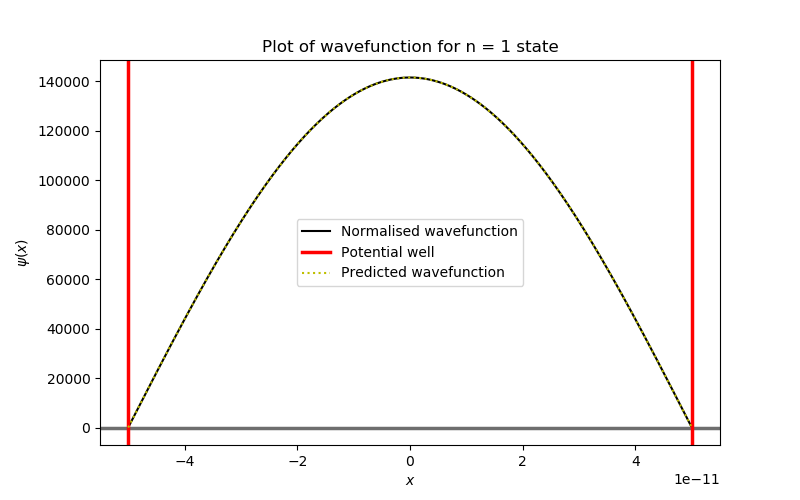

The normalisation constant c = 8885765876434121.0


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


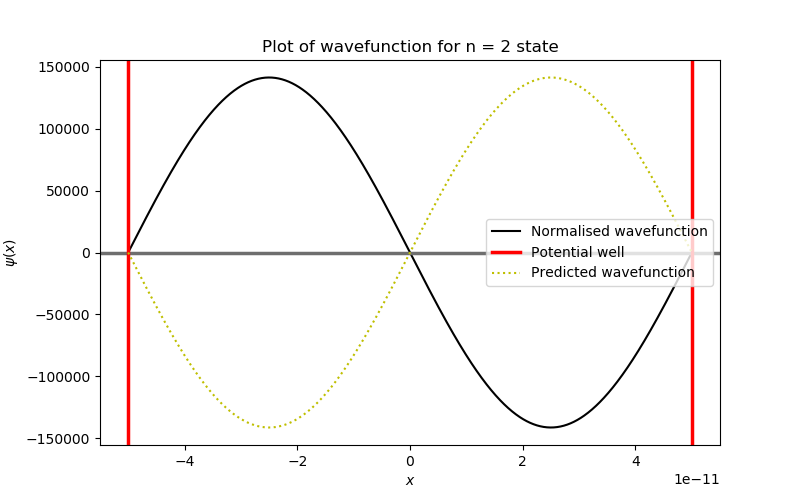

The normalisation constant c = 1.3328648815383976e+16


<IPython.core.display.Javascript object>


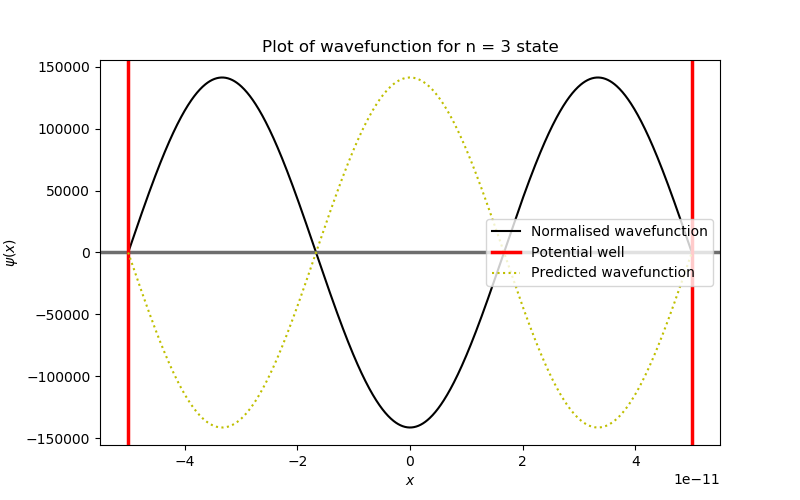

The normalisation constant c = 1.7771531756569426e+16


<IPython.core.display.Javascript object>


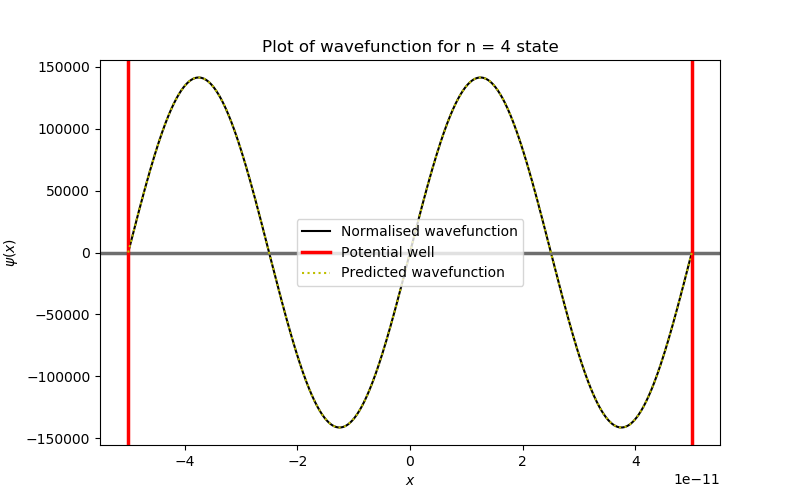

The normalisation constant c = 1.0662928714851482e+17


<IPython.core.display.Javascript object>


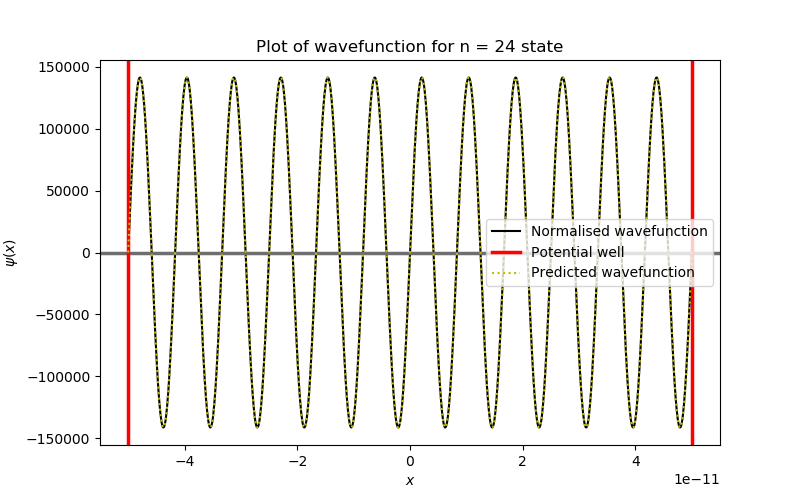

The normalisation constant c = 1.1107219904785659e+17


<IPython.core.display.Javascript object>


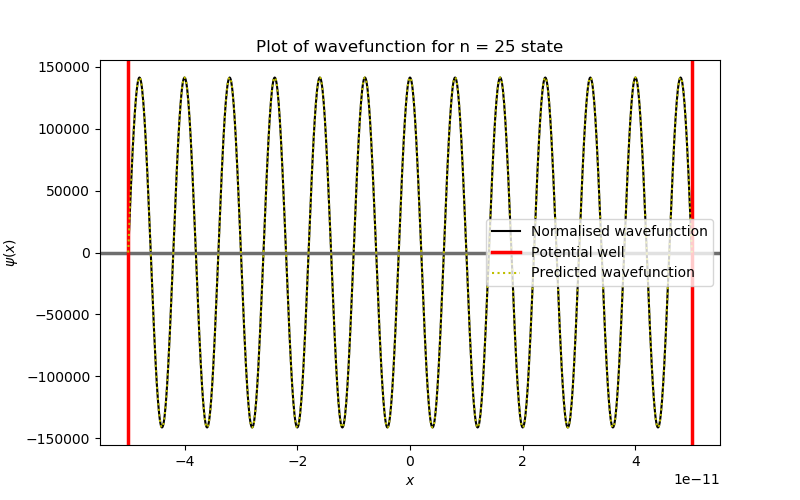

In [27]:
# i = 0, this is used to update n for each iteration of the below for loop
i = 0

for E in Evalues_zero:
    n = states_zero[i]
    
    wavefunction = RK2D(r,xpoints,E,Vzero)[0,:]
    
    # same as xpoints but with an extra xf+h point, since there is an extra point calculated from the Runge Kutta function
    xplot = np.arange(xi, xf+h, h)

    # trapezoidal rule to calculate integral 
    I = np.trapz(abs(wavefunction)**2,xplot)
    
    # finding normalisation constant, c
    c = 1/np.sqrt(I)
    print("The normalisation constant c =", c)
    
    # calculating normalised numerical values for the wavefunction
    norm_wave = c*wavefunction
    
    #plotting the normalised wavefunction
    plt.figure(figsize=(8,5))
    plt.plot(xplot,norm_wave,'k', label = 'Normalised wavefunction')
    
    # plots line at y = 0
    plt.axhline(y = 0,c='#6e6e6e',ls='-',lw=2.5)
    
    # plots infinite potential well
    plt.axvline(x=-a,c='red',ls='-',lw=2.5, label='Potential well')
    plt.axvline(x=a,c='red',ls='-',lw=2.5)
    
    plt.xlabel('$x$')
    plt.ylabel('$\psi(x)$')
    plt.title("Plot of wavefunction for n = {0:} state".format(n))
    
    # changes the predicted wavefunction for whether n= odd or even
    if (-1)**n == 1:
        yeven = 1/np.sqrt(a)*np.sin(np.pi*xplot*n/(2*a))
        plt.plot(xplot,yeven,'y:', label = 'Predicted wavefunction')
    
    elif (-1)**n == -1:
        yodd = 1/np.sqrt(a)*np.cos(np.pi*xplot*n/(2*a))
        plt.plot(xplot,yodd,'y:', label = 'Predicted wavefunction')
    
    i = i+1
    
    plt.legend(loc='best');

#### With flipping case:

As can be seen below, in the flipping case the wave functions match all the predicted wavefunctions $\psi_{n}(x)$.

The normalisation constant c = 4442882938162023.0


<IPython.core.display.Javascript object>


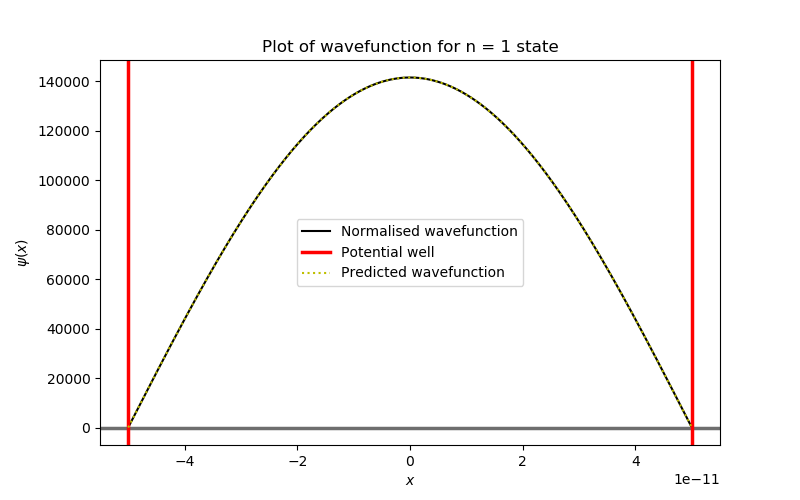

The normalisation constant c = 8885765876434121.0


<IPython.core.display.Javascript object>


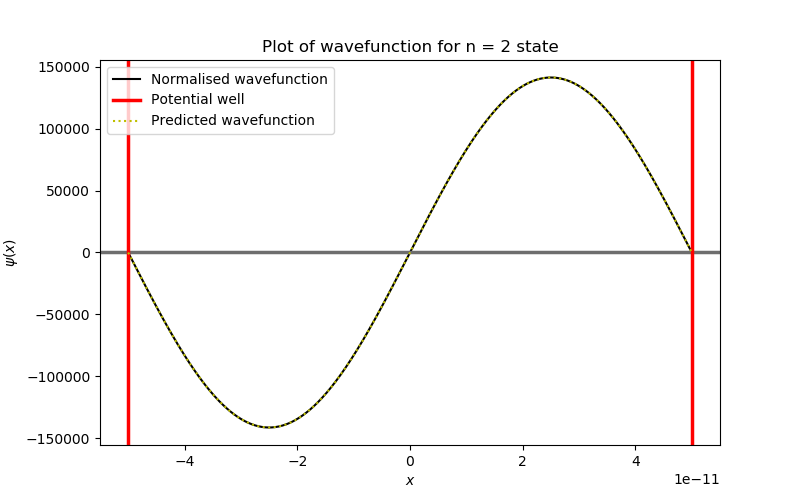

The normalisation constant c = 1.3328648815383976e+16


<IPython.core.display.Javascript object>


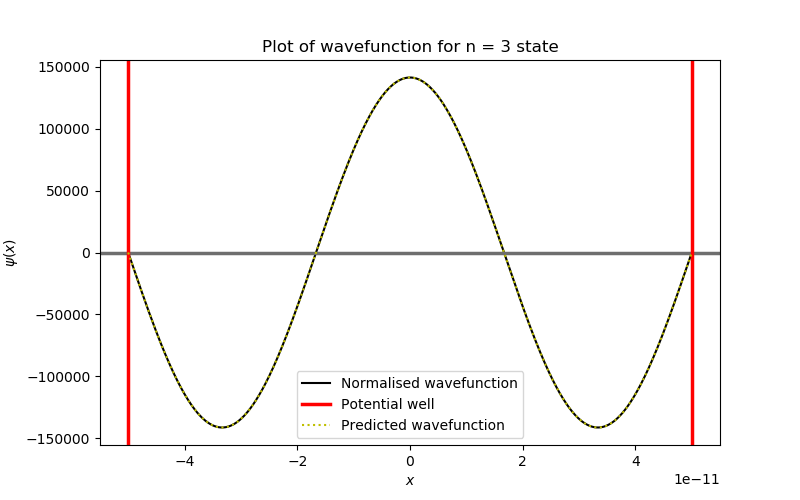

The normalisation constant c = 1.7771531756569426e+16


<IPython.core.display.Javascript object>


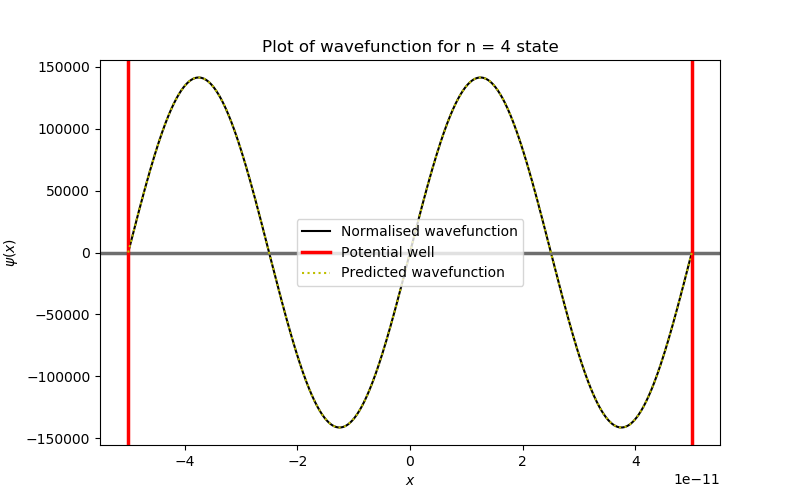

The normalisation constant c = 1.0662928714851482e+17


<IPython.core.display.Javascript object>


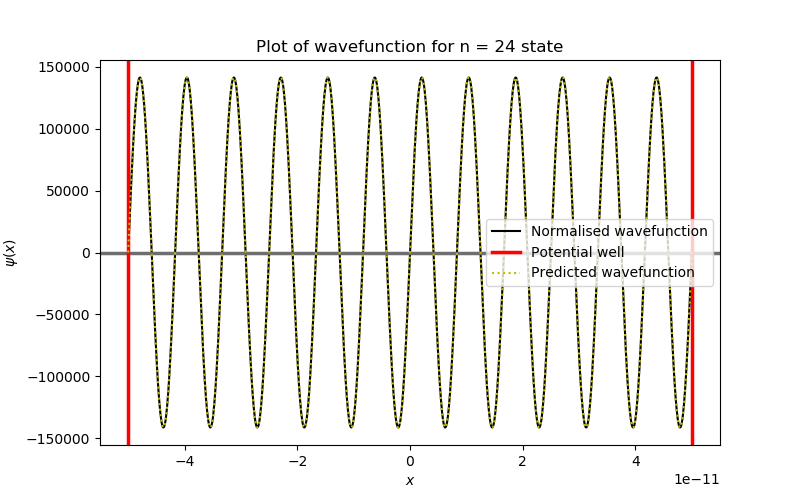

The normalisation constant c = 1.1107219904785659e+17


<IPython.core.display.Javascript object>


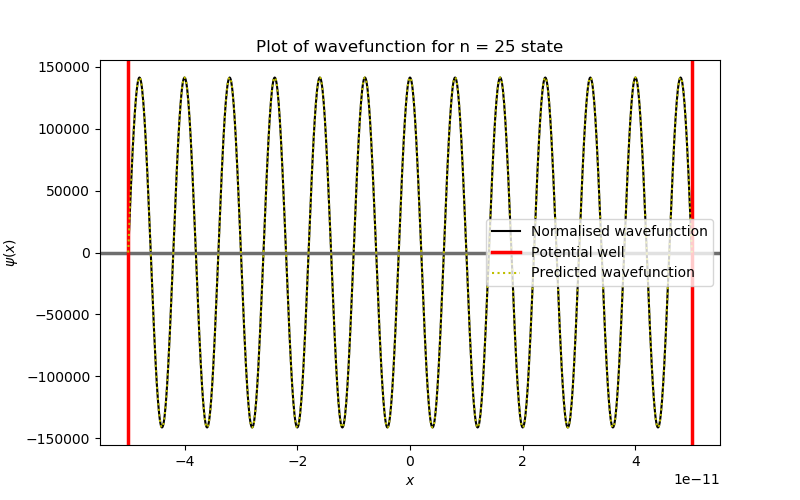

In [26]:
i = 0

for E in Evalues_zero:
    
    n = states_zero[i]
    
    #taking into account the flipping case
    if (n+2)%4==0:
        R = rflip
    elif (n+1)%4==0:
        R = rflip
    else:
        R = r
        
    wavefunction = RK2D(R,xpoints,E,Vzero)[0,:]
    
    # same as xpoints but with xf+h calcaulted from the Runge Kutta function
    xplot = np.arange(xi, xf+h, h)

    # trapezoidal rule to calculate integral 
    I = np.trapz(abs(wavefunction)**2,xplot)
    
    
    # finding normalisation constant, c
    c = 1/np.sqrt(I)
    print("The normalisation constant c =", c)
    
    # calculating normalised numerical values for the wavefunction
    norm_wave = c*wavefunction
    
    #plotting the normalised wavefunction
    plt.figure(figsize=(8,5))
    plt.plot(xplot,norm_wave,'k', label = 'Normalised wavefunction')
    plt.axhline(y = 0,c='#6e6e6e',ls='-',lw=2.5)
    plt.axvline(x=-a,c='red',ls='-',lw=2.5, label='Potential well')
    plt.axvline(x=a,c='red',ls='-',lw=2.5)
    plt.xlabel('$x$')
    plt.ylabel('$\psi(x)$')
    plt.title("Plot of wavefunction for n = {0:} state".format(n))
    
    if (-1)**n == 1:
        yeven = 1/np.sqrt(a)*np.sin(np.pi*xplot*n/(2*a))
        plt.plot(xplot,yeven,'y:', label = 'Predicted wavefunction')
    
    elif (-1)**n == -1:
        yodd = 1/np.sqrt(a)*np.cos(np.pi*xplot*n/(2*a))
        plt.plot(xplot,yodd,'y:', label = 'Predicted wavefunction')
    
    i = i+1
    
    plt.legend(loc='best');

### Embedded finite square well:

I could not find anlytic solutions for the finite square well so I will compare the wavefunctions to the infinite square well. The text cell comparing these are below the following code cell and plots.

Energy eigenvalue, E1 = 85.66151943011151 eV
The normalisation constant c = 827073242564497.5


<IPython.core.display.Javascript object>


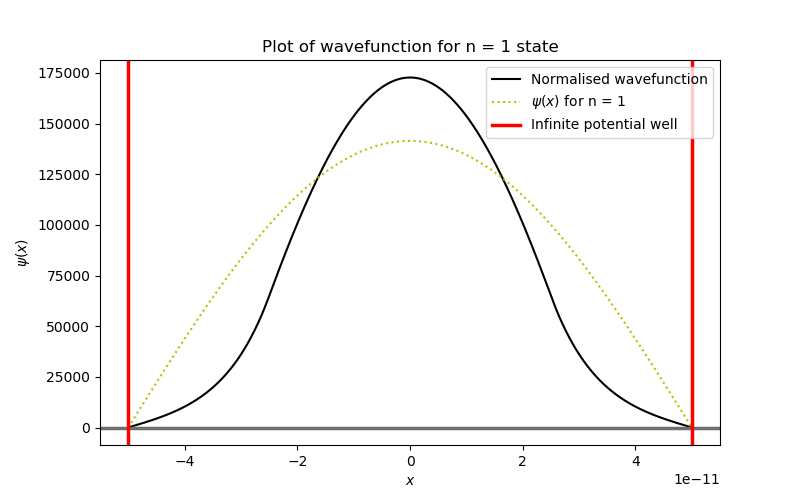

Energy eigenvalue, E2 = 328.8690217719838 eV
The normalisation constant c = 2523765962584555.5


<IPython.core.display.Javascript object>


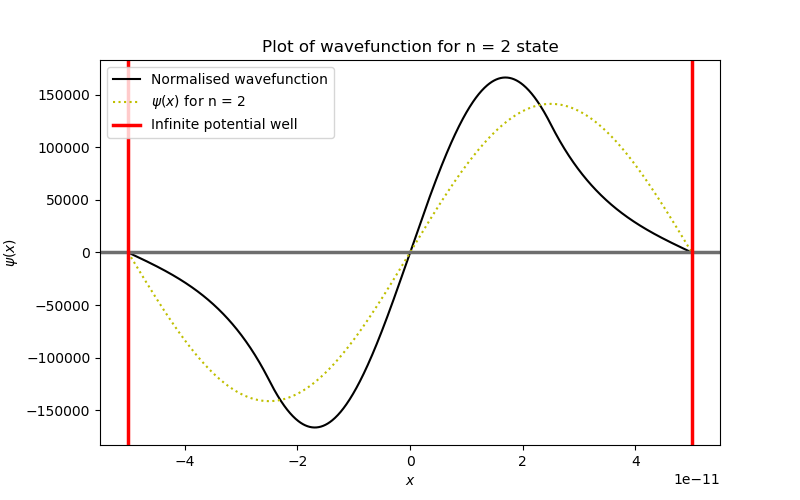

Energy eigenvalue, E3 = 670.1785607707463 eV
The normalisation constant c = 7136361165914291.0


<IPython.core.display.Javascript object>


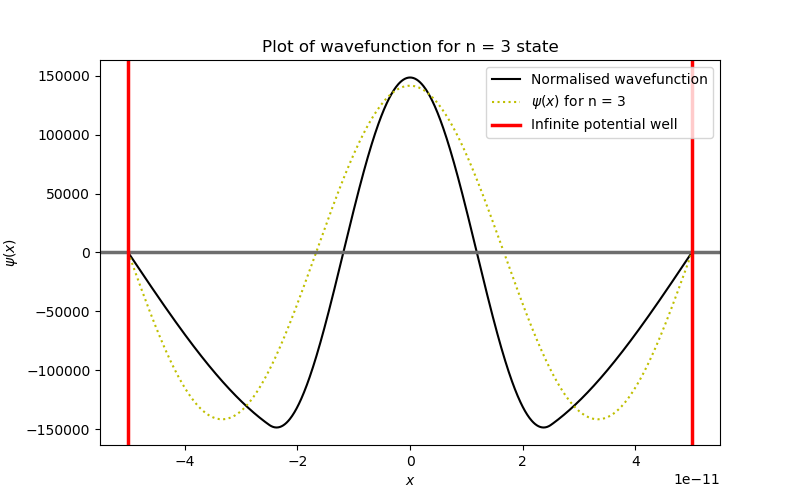

Energy eigenvalue, E4 = 981.9554610786822 eV
The normalisation constant c = 1.526884336610963e+16


<IPython.core.display.Javascript object>


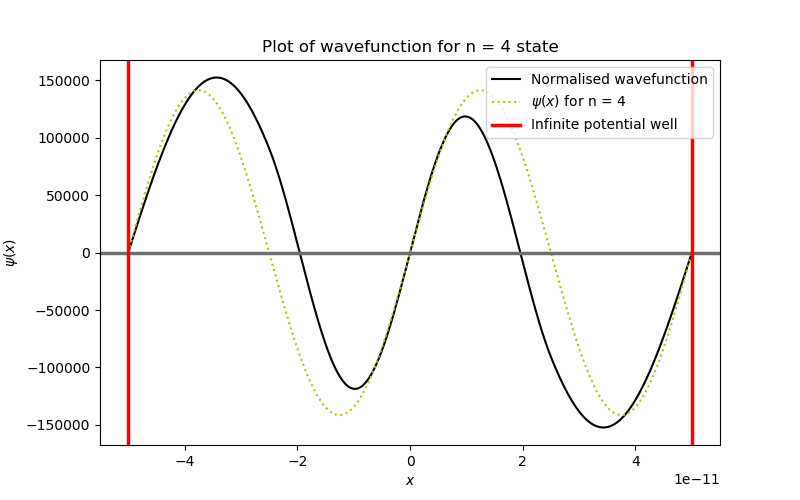

Energy eigenvalue, E5 = 1252.5563921539651 eV
The normalisation constant c = 2.1293594199493804e+16


<IPython.core.display.Javascript object>


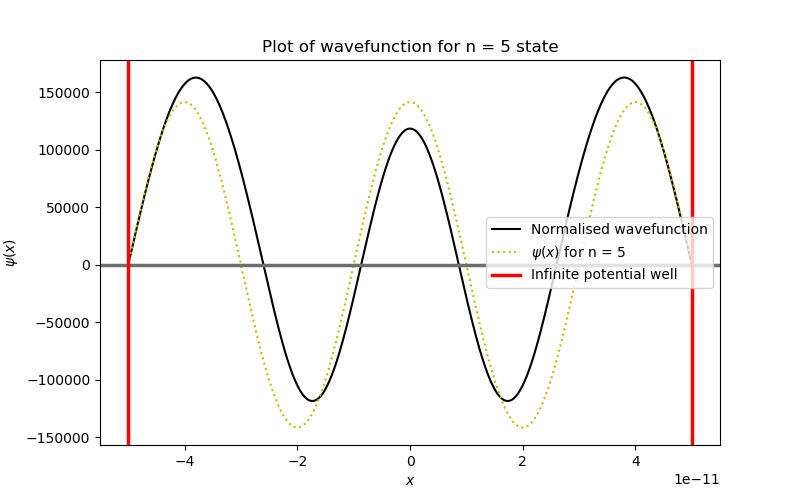

Energy eigenvalue, E6 = 1642.5006777504273 eV
The normalisation constant c = 2.4304668268081556e+16


<IPython.core.display.Javascript object>


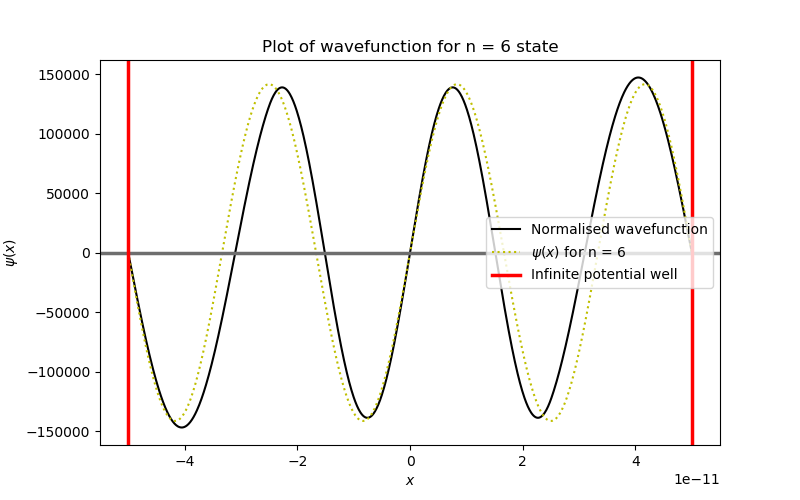

<IPython.core.display.Javascript object>


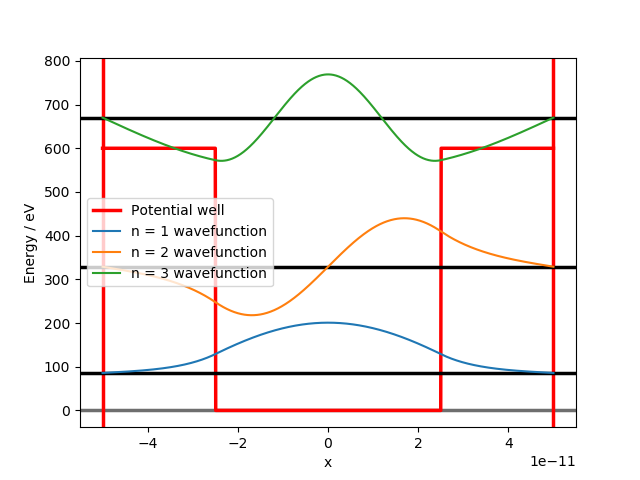

In [46]:
# initial conditions [psi,phi] 
r = np.array([0, 1]) ## normalised after (can choose any value)
rflip = np.array([0, -1])

# maximum number of energy states to solve for
nmax = 6

# finds energy eigenvlaues using guessing and secant methods
Eguesses = Eguesser(r,xpoints,nmax,Vfinite)
Eapprox_finite = secant(r,xpoints,Eguesses,Vfinite)

# initialises array which will contain all calculated normalized wavefunctions for the embedded finite well potential
norm_wave_finite = np.array([])

# initial n
n = 1

for E in Eapprox_finite:
    # prints energy eigenvalues
    print("Energy eigenvalue, E{0:} =".format(n), E, "eV")
    
    # taking into account the flipping
    if (n+2)%4==0:
        R = rflip
    elif (n+1)%4==0:
        R = rflip
    else:
        R = r
    
    # wavefunction for embedded finite potential obtained from Runge-Kutta function
    wavefunction = RK2D(R,xpoints,E,Vfinite)[0,:]
    
    # same as xpoints but with xf+h calcaulted from the Runge Kutta function
    xplot = np.arange(xi, xf+h, h)

    # trapezoidal rule to calculate integral 
    I = np.trapz(abs(wavefunction)**2,xplot)
    
    # finding normalisation constant, c
    c = 1/np.sqrt(I)
    print("The normalisation constant c =", c)

    # calculating normalised numerical values for the wavefunction and appends them to an array
    norm_wave_finite = np.append(norm_wave_finite, c*wavefunction)
        
    # plotting the normalised wavefunction
    plt.figure(figsize=(8,5))
    # calls out normalized wavefunction from array 'norm_wave_finite' and plots it
    plt.plot(xplot,norm_wave_finite[(n-1)*len(wavefunction):(n)*len(wavefunction)],'k', label = 'Normalised wavefunction')

    # plotted to compare to infinite square well analytical solutions
    if (-1)**n == 1:
        yeven = 1/np.sqrt(a)*np.sin(np.pi*xplot*n/(2*a))
        plt.plot(xplot,yeven,'y:', label = '$\psi(x)$ for n = {0:}'.format(n))
    
    elif (-1)**n == -1:
        yodd = 1/np.sqrt(a)*np.cos(np.pi*xplot*n/(2*a))
        plt.plot(xplot,yodd,'y:', label = '$\psi(x)$ for n = {0:}'.format(n))
        
    plt.axhline(y = 0,c='#6e6e6e',ls='-',lw=2.5)
    plt.axvline(x=-a,c='red',ls='-',lw=2.5, label='Infinite potential well')
    plt.axvline(x=a,c='red',ls='-',lw=2.5)
    plt.xlabel('$x$')
    plt.ylabel('$\psi(x)$')
    plt.title("Plot of wavefunction for n = {0:} state".format(n))
    
    plt.legend(loc='best') ;
    
    # updates state number
    n = n+1

def finite_plot(x):
    """Calculates potential for V(x) = V0finite for |x| > a/2, 0 for |x| <= a/2, for an array of x points
    Input:
        x [array]: x point value (m)
    Output:
        Vfinite(x) [array]: solutions for the above potential in eV (2)
    """
    finiteplot = np.array([])
    for z in range(0,len(x)):
        if abs(x[z]) > a/2:
            finiteplot = np.append(finiteplot, V0finite/e)
        else:
            finiteplot = np.append(finiteplot, 0)      
    return finiteplot

#plots energy eigenvalues on embedded potential with scaled wavefunctions
plt.figure()
plt.axhline(y = 0,c='#6e6e6e',ls='-',lw=2.5)
plt.axvline(x=-a,c='red',ls='-',lw=2.5, label='Potential well')
plt.axvline(x=a,c='red',ls='-',lw=2.5)
plt.plot(xplot,finite_plot(xplot),'r',lw=2.5)
for t in range(0,int(len(Eapprox_finite)/2)):
    plt.axhline(y = Eapprox_finite[t],c='k',ls='-',lw=2.5)
    plt.plot(xplot, norm_wave_finite[t*len(wavefunction):(t+1)*len(wavefunction)]/1500 + Eapprox_finite[t], label = "n = {0:} wavefunction".format(t+1))
plt.xlabel("x")
plt.ylabel("Energy / eV")
plt.legend(loc="best");

As you can see for the n=1 to n=6 states, the wavefunction for the finite square well starts to increasingly match the infinite square well predictions. This is because as the energy eigenvalue increases, the finite well starts to have less of an impact on the wavefunction and will start to become a small perturbation for n>>1. This can also be seen on the eigenstates and potential plot above where the eigenstates eventually go over the finite well, and as discussed before when n>>1 it becomes a small perturbation and there will be near negligable differences between the predicted and embedded finite well wavefunctions.

Another comment is that the finite well solutions inside the well are of the form $\psi(x) = \alpha e^{\pm\beta x}$, which means that $\psi(x) = 0$ only for $ x \rightarrow \infty$. However this doesn't happen in our case due to the finite square well being embedded into an infinite square well which gives it the following boundary conditions:

(11):
$$ \psi(-a) = 0 $$

(12):
$$ \psi(a) = 0 $$

### Embedded harmonic potential:

Unlike both finite and infinite square wells, the flipping for the harmonic embedded potential follows a different pattern of $ n_{flipped} = 2x $ where $x$ $\epsilon$ $\mathbb{Z}^+$. This pattern is different due to the form of the harmonic potentials.

Energy eigenvalue, E1 = 103.91852037987628 eV
The normalisation constant c = 1434961682117039.8


<IPython.core.display.Javascript object>


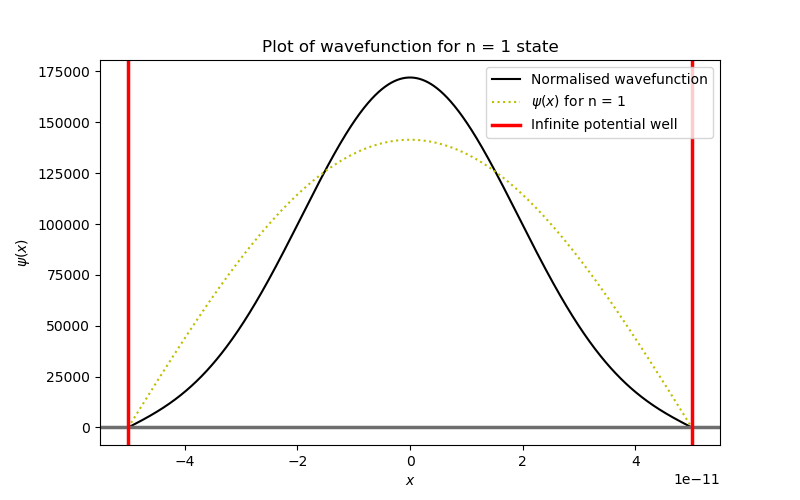

Energy eigenvalue, E2 = 317.008629986823 eV
The normalisation constant c = 4386517343998745.5


<IPython.core.display.Javascript object>


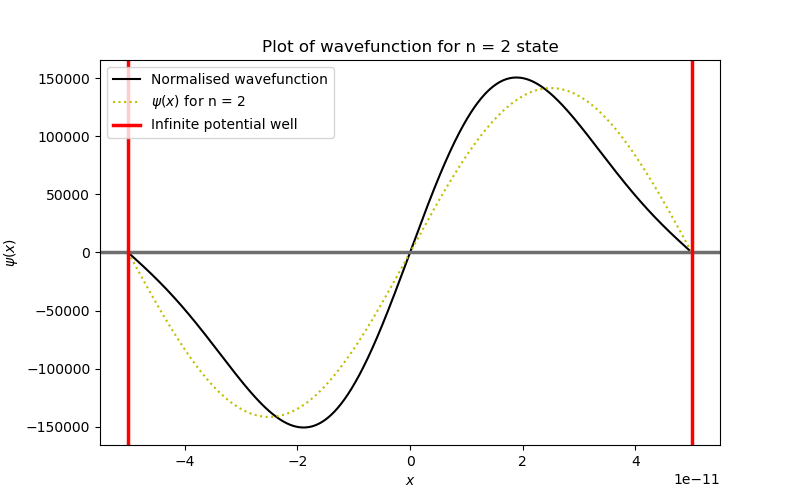

Energy eigenvalue, E3 = 551.9027823586961 eV
The normalisation constant c = 8803181588872537.0


<IPython.core.display.Javascript object>


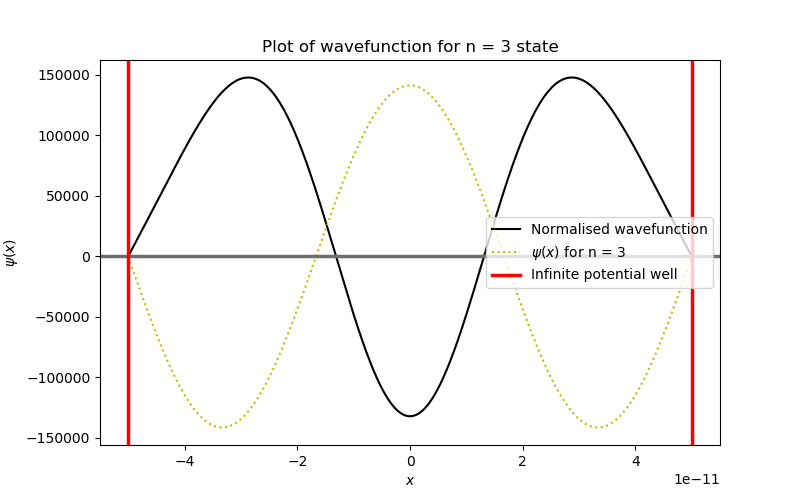

Energy eigenvalue, E4 = 831.7403331138896 eV
The normalisation constant c = 1.3921670722615476e+16


<IPython.core.display.Javascript object>


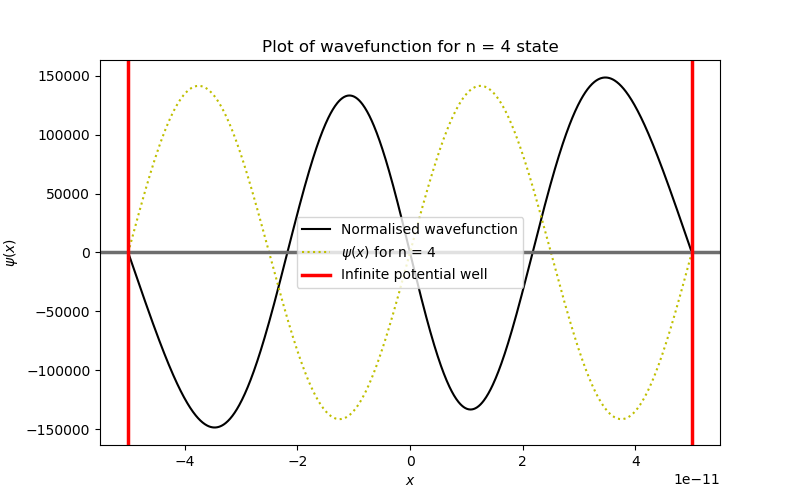

Energy eigenvalue, E5 = 1174.6747844495958 eV
The normalisation constant c = 1.909676794688006e+16


<IPython.core.display.Javascript object>


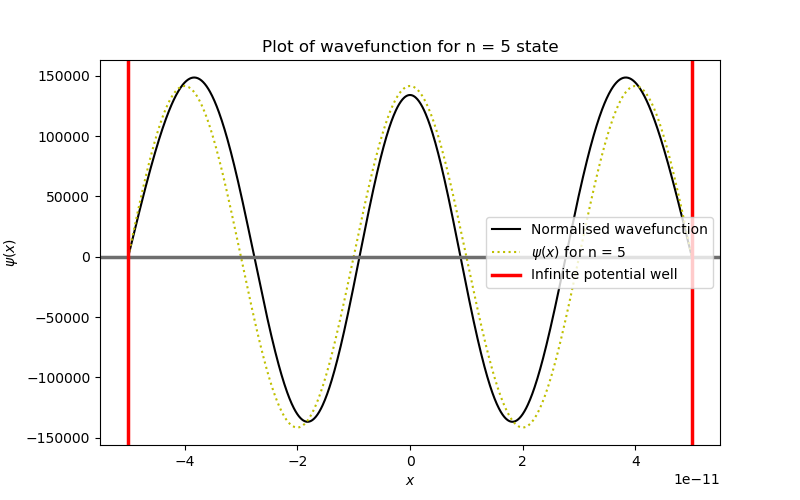

Energy eigenvalue, E6 = 1589.1596333490509 eV
The normalisation constant c = 2.4106634505446376e+16


<IPython.core.display.Javascript object>


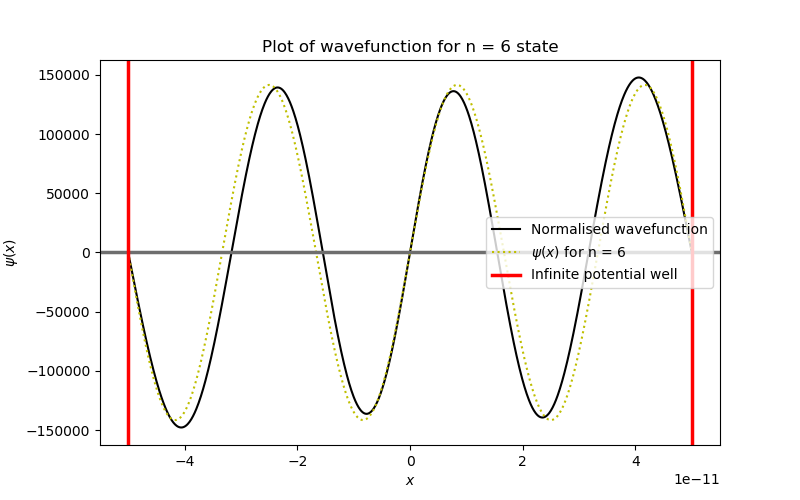

<IPython.core.display.Javascript object>


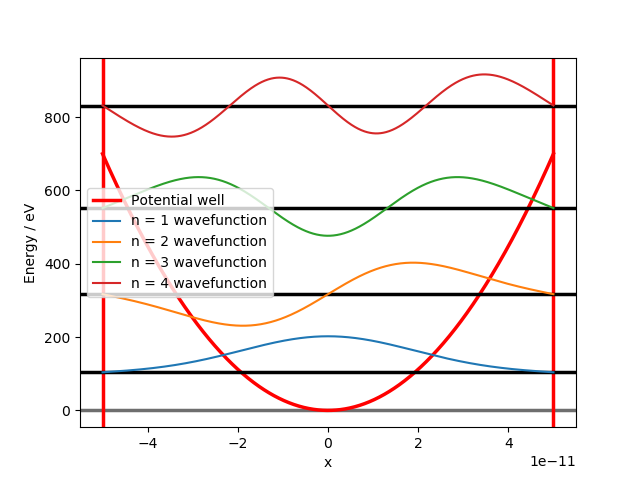

In [41]:
# initial conditions [psi,phi] 
r = np.array([0, 1]) ## normalised after (can choose any value)
rflip = np.array([0, -1])

# maximum number of energy states to solve for
nmax = 6

# finds energy eigenvlaues using guessing and secant methods
Eguesses = Eguesser(r,xpoints,nmax,Vharmonic)
Eapprox_harmonic = secant(r,xpoints,Eguesses,Vharmonic)

# initial n
n = 1

# initialises array which will contain all calculated normalized wavefunctions for the embedded harmonic potential
norm_wave_harmonic = np.array([])

for E in Eapprox_harmonic:
    # prints energy eigenvalues
    print("Energy eigenvalue, E{0:} =".format(n), E, "eV")
    
    # taking into account the harmonic flipping
    if n%2 ==0:
        R = rflip 
    else:
        R = r
    
    # wavefunction for embedded harmonic potential obtained from Runge-Kutta function
    wavefunction = RK2D(R,xpoints,E,Vharmonic)[0,:]
    
    # same as xpoints but with xf+h calcaulted from the Runge Kutta function
    xplot = np.arange(xi, xf+h, h)

    # trapezoidal rule to calculate integral 
    I = np.trapz(abs(wavefunction)**2,xplot)
    
    # finding normalisation constant, c
    c = 1/np.sqrt(I)
    print("The normalisation constant c =", c)

    # calculating normalised numerical values for the wavefunction
    norm_wave_harmonic = np.append(norm_wave_harmonic, c*wavefunction)
    
    #plotting the normalised wavefunction
    plt.figure(figsize=(8,5))
    
    # calls out normalized wavefunction from array 'norm_wave_harmonic' and plots it
    plt.plot(xplot,norm_wave_harmonic[(n-1)*len(wavefunction):(n)*len(wavefunction)],'k', label = 'Normalised wavefunction')
    
    if (-1)**n == 1:
        yeven = 1/np.sqrt(a)*np.sin(np.pi*xplot*n/(2*a))
        plt.plot(xplot,yeven,'y:', label = '$\psi(x)$ for n = {0:}'.format(n))
    
    elif (-1)**n == -1:
        yodd = 1/np.sqrt(a)*np.cos(np.pi*xplot*n/(2*a))
        plt.plot(xplot,yodd,'y:', label = '$\psi(x)$ for n = {0:}'.format(n))
    
    plt.axhline(y = 0,c='#6e6e6e',ls='-',lw=2.5)
    plt.axvline(x=-a,c='red',ls='-',lw=2.5, label='Infinite potential well')
    plt.axvline(x=a,c='red',ls='-',lw=2.5)
    plt.xlabel('$x$')
    plt.ylabel('$\psi(x)$')
    plt.title("Plot of wavefunction for n = {0:} state".format(n))
    
    plt.legend(loc='best');
    
    # updates state number
    n = n+1

#plots energy eigenvalues on embedded potential with scaled wavefunctions
plt.figure()
plt.axhline(y = 0,c='#6e6e6e',ls='-',lw=2.5)
plt.axvline(x=-a,c='red',ls='-',lw=2.5, label='Potential well')
plt.axvline(x=a,c='red',ls='-',lw=2.5)

harmonic_plot = V0harmonic/e*(xplot/a)**2
plt.plot(xplot, harmonic_plot, 'r',lw=2.5)

for t in range(0,len(Eapprox_harmonic)-2):
    plt.axhline(y = Eapprox_harmonic[t],c='k',ls='-',lw=2.5)
    plt.plot(xplot, norm_wave_harmonic[t*len(wavefunction):(t+1)*len(wavefunction)]/1750 + Eapprox_harmonic[t], label = "n = {0:} wavefunction".format(t+1))
plt.xlabel("x")
plt.ylabel("Energy / eV")
plt.legend(loc="best");

Similar to the embedded finite potential wavefunction case, as the energy states increase to the limit n>>1 then the harmonic potential becomes a small perturbation to the infinite potential meaning the resultant wavefunction will be similar to those of the infinite square well.

In addition to this, the wavefunctions for the harmonic and finite embedded square potentials are similar. This is becuase the harmonic potential is the finite potential but with an increasing finite well length and potential of the well with an increase in the energy states. This is particularly clear in our case as we have embedded the bottom part of the harmonic potential (where $V_0$ values are low) meaning there will be little difference between the embedded finite and harmonic wavefunctions.

The embedded harmonic potential also has a similar problem to the embedded finite potential as the infinite square well forces the above boundary conditions (11) and (12), meaning the exponential inside the harmonic potential goes to zero faster than it normally would without being embedded by an infinite square well.

Some of the harmonic potentials are flipped compared to the infinite square well and this is due to how the harmonic potential wavefunctions are derived.

### Embedded perturbation potential:

The below perturbation potential was chosen as it links into the case for both the embedded finite and infinite potentials. This potential would allow us to see what effect a potential can have on a wavefunction for $E>>V(x)$:

(13):
$$
V_x = \begin{cases} 0 & \text{if } x \leq 0, \\ 
    V_0  & \text{if } x > 0, \end{cases} 
$$

In [48]:
def Vpert(x):
    """Calculates potential for a small perturbation of 50 eV for x>0
    Input:
        x [string]: x point value (m)
    Output:
        Vpert(x) [string]: solutions for the above potential in Joules (3)
    """
    if x>0:
        x = V0pert
    else:
        x=0
    
    return x

V0pert = 50*e

Energy eigenvalue, E1 = 58.55682068033365 eV
The normalisation constant c = 5850359073557796.0


<IPython.core.display.Javascript object>


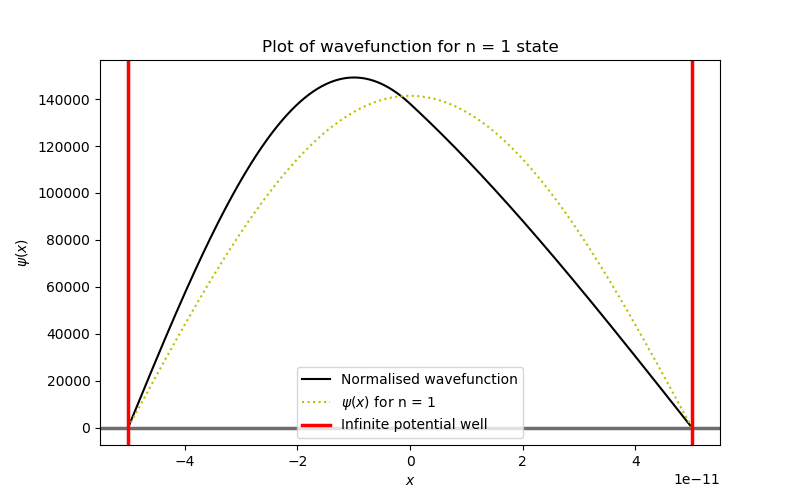

Energy eigenvalue, E2 = 178.3909223916482 eV
The normalisation constant c = 8852836861950540.0


<IPython.core.display.Javascript object>


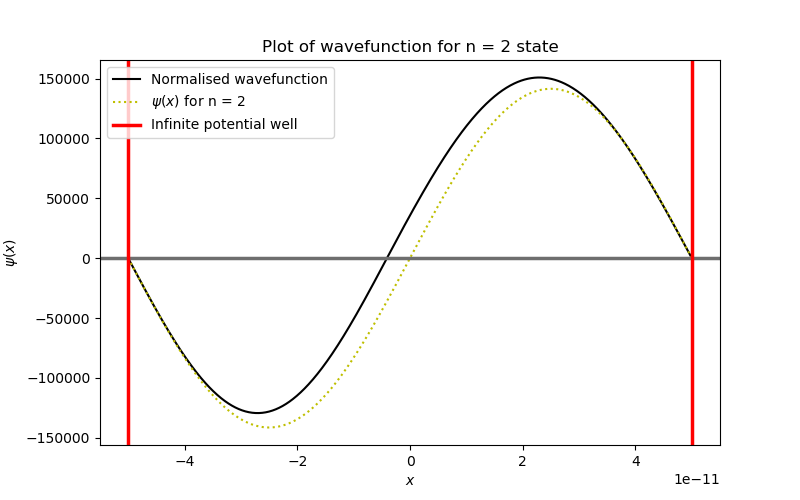

Energy eigenvalue, E3 = 362.9660032785889 eV
The normalisation constant c = 1.3806517806962172e+16


<IPython.core.display.Javascript object>


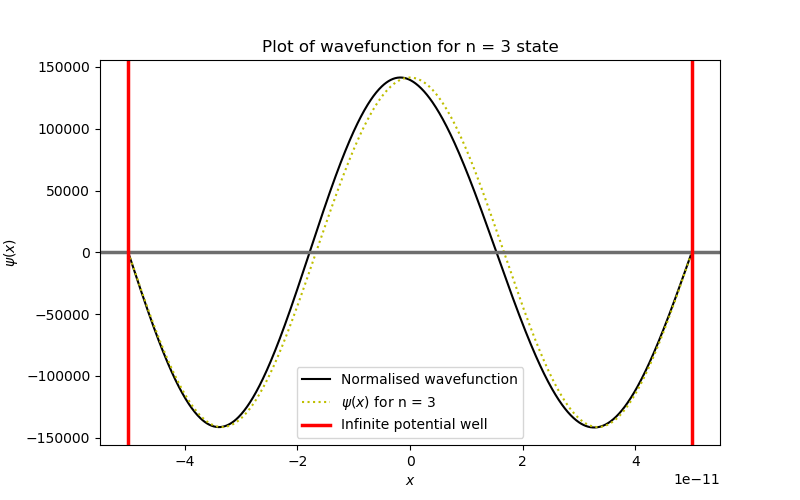

Energy eigenvalue, E4 = 627.4204465056312 eV
The normalisation constant c = 1.776676059641705e+16


<IPython.core.display.Javascript object>


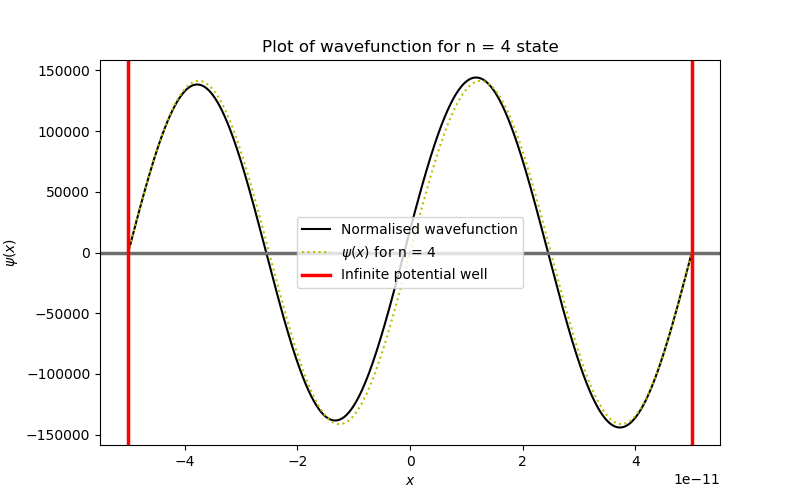

Energy eigenvalue, E5 = 964.8950304874055 eV
The normalisation constant c = 2.250638983837722e+16


<IPython.core.display.Javascript object>


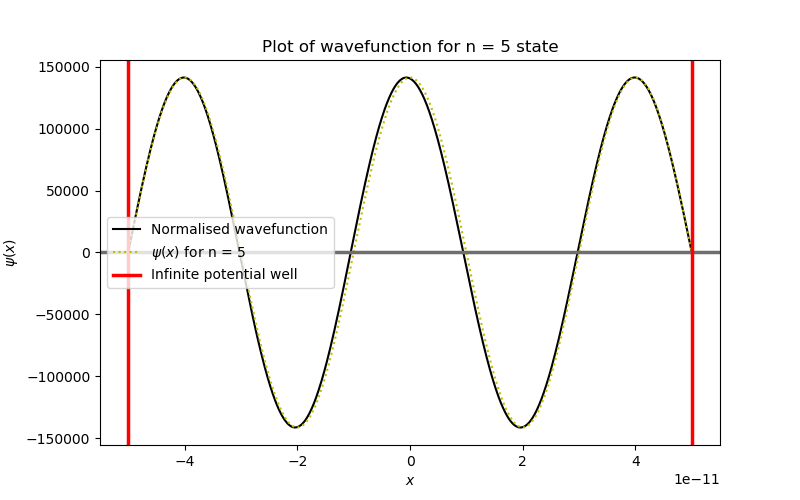

Energy eigenvalue, E6 = 1379.0534998811227 eV
The normalisation constant c = 2.6655918765453624e+16


<IPython.core.display.Javascript object>


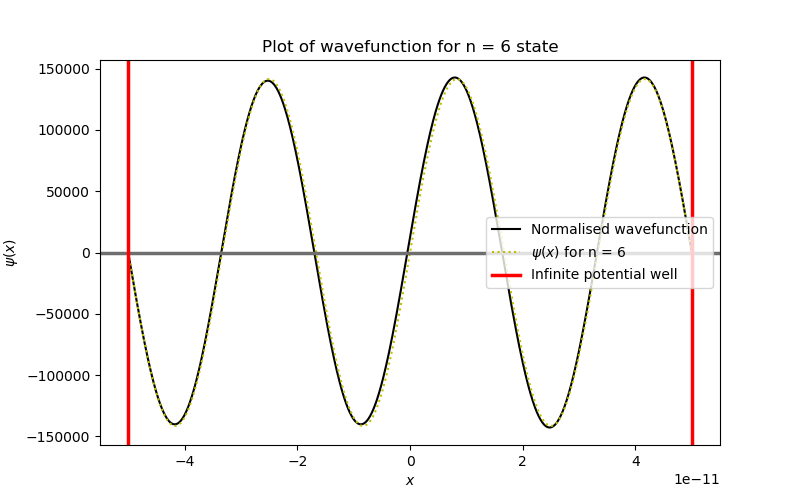

<IPython.core.display.Javascript object>


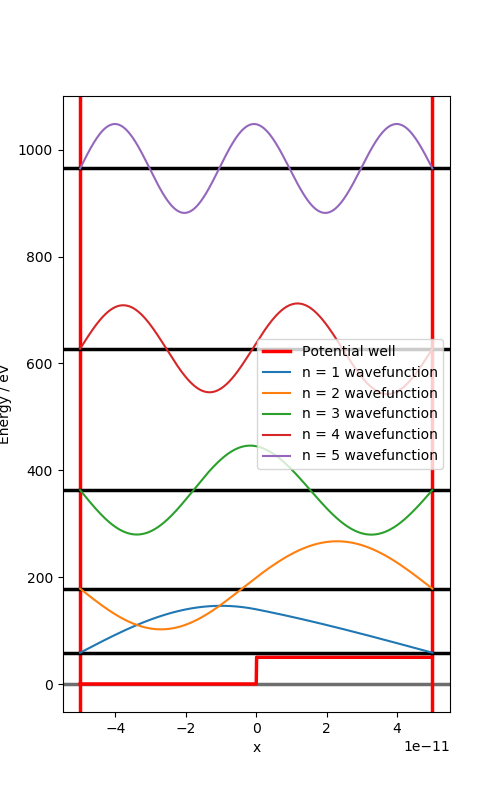

In [54]:
# initial conditions [psi,phi] 
r = np.array([0, 1]) ## normalised after (can choose any value)
rflip = np.array([0, -1])

# maximum number of energy states to solve for
nmax = 6

# finds energy eigenvlaues using guessing and secant methods
Eguesses = Eguesser(r,xpoints,nmax,Vpert)
Eapprox_pert = secant(r,xpoints,Eguesses,Vpert)

# initial n
n = 1

# initialises array which will contain all calculated normalized wavefunctions for the embedded perturbation potential
norm_wave_pert = np.array([])

for E in Eapprox_pert:
    # prints energy eigenvalues
    print("Energy eigenvalue, E{0:} =".format(n), E, "eV")
    
    #taking into account the flipping case
    if (n+2)%4==0:
        R = rflip
    elif (n+1)%4==0:
        R = rflip
    else:
        R = r
    
    # wavefunction for embedded perturbation potential obtained from Runge-Kutta function
    wavefunction = RK2D(R,xpoints,E,Vpert)[0,:]
    
    # same as xpoints but with xf+h calcaulted from the Runge Kutta function
    xplot = np.arange(xi, xf+h, h)

    # trapezoidal rule to calculate integral 
    I = np.trapz(abs(wavefunction)**2,xplot)
    
    # finding normalisation constant, c
    c = 1/np.sqrt(I)
    print("The normalisation constant c =", c)

    # calculating normalised numerical values for the wavefunction
    norm_wave_pert = np.append(norm_wave_pert, c*wavefunction)
        
    #plotting the normalised wavefunction
    plt.figure(figsize=(8,5))
    plt.plot(xplot,norm_wave_pert[(n-1)*len(wavefunction):(n)*len(wavefunction)],'k', label = 'Normalised wavefunction')
    
    if (-1)**n == 1:
        yeven = 1/np.sqrt(a)*np.sin(np.pi*xplot*n/(2*a))
        plt.plot(xplot,yeven,'y:', label = '$\psi(x)$ for n = {0:}'.format(n))
    
    elif (-1)**n == -1:
        yodd = 1/np.sqrt(a)*np.cos(np.pi*xplot*n/(2*a))
        plt.plot(xplot,yodd,'y:', label = '$\psi(x)$ for n = {0:}'.format(n))
    
    #plotting the infinite potential well lines
    plt.axhline(y = 0,c='#6e6e6e',ls='-',lw=2.5)
    plt.axvline(x=-a,c='red',ls='-',lw=2.5, label='Infinite potential well')
    plt.axvline(x=a,c='red',ls='-',lw=2.5)
    plt.xlabel('$x$')
    plt.ylabel('$\psi(x)$')
    plt.title("Plot of wavefunction for n = {0:} state".format(n))
    
    plt.legend(loc='best');
    n = n+1
    
def pert_plot(x):
    """Calculates potential for V(x) = V0pert for x > 0, 0 for x <= 0, for an array of x points
    Input:
        x [array]: x point value (m)
    Output:
        Vfinite(x) [array]: solutions for the above potential in eV (2)
    """
    pertplot = np.array([])
    for z in range(0,len(x)):
        if x[z] > 0:
            pertplot = np.append(pertplot, V0pert/e)
        else:
            pertplot = np.append(pertplot, 0)
        
    return pertplot

#plots energy eigenvalues on embedded potential with scaled wavefunctions
plt.figure(figsize=(5,8))
plt.axhline(y = 0,c='#6e6e6e',ls='-',lw=2.5)
plt.axvline(x=-a,c='red',ls='-',lw=2.5, label='Potential well')
plt.axvline(x=a,c='red',ls='-',lw=2.5)
plt.plot(xplot,pert_plot(xplot),'r',lw=2.5)
for t in range(0,len(Eapprox_pert)-1):
    plt.axhline(y = Eapprox_pert[t],c='k',ls='-',lw=2.5)
    plt.plot(xplot, norm_wave_pert[t*len(wavefunction):(t+1)*len(wavefunction)]/1700 + Eapprox_pert[t], label = "n = {0:} wavefunction".format(t+1))
plt.xlabel("x")
plt.ylabel("Energy / eV")
plt.legend(loc="best");

As can be seen in the n=1 case, the embedded perturbation potential has an effect on the wavefunction due to $E_1 \approx V_{pert}(x)$. However, as n gets larger (ex.n=6) the wavefunction starts to strongly resemble the infinite square well as the perturbation starts to have less effect. By looking at the last plot it can be seen how small the perturbation becomes relative to the energy eigenvalue as the energy state increases (from n=1 to n=6)

Unless there are known wavefunctions or an analytic solution then the relation between flipping and energy states cannot be known, however as the perturbation potential follows a similar form as to the finite square well they will have the same flipping relation.